In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite 
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));

In [3]:
include("../src/unit_commitments.jl")

# A spring day
n=100
T_period = (n*24+6):(n*24+30)

# gen_df = gen_df[gen_df.r_id .!= 119, :]

# gen_df = gen_df[gen_df.technology .!= "Conventional Hydroelectric", :]
loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]

gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 51324 rows; 27300 cols; 153375 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
36965 rows, 26870 cols, 132488 nonzeros  0s
28077 rows, 21432 cols, 114718 nonzeros  0s
20849 rows, 19722 cols, 104541 nonzeros  0s
17632 rows, 16812 cols, 99758 nonzeros  1s
16093 rows, 15376 cols, 95231 nonzeros  2s

Solving MIP model with:
   16093 rows
   15376 cols (8838 binary, 0 integer, 0 implied int., 6538 continuous, 0 domain fixed)
   95231 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

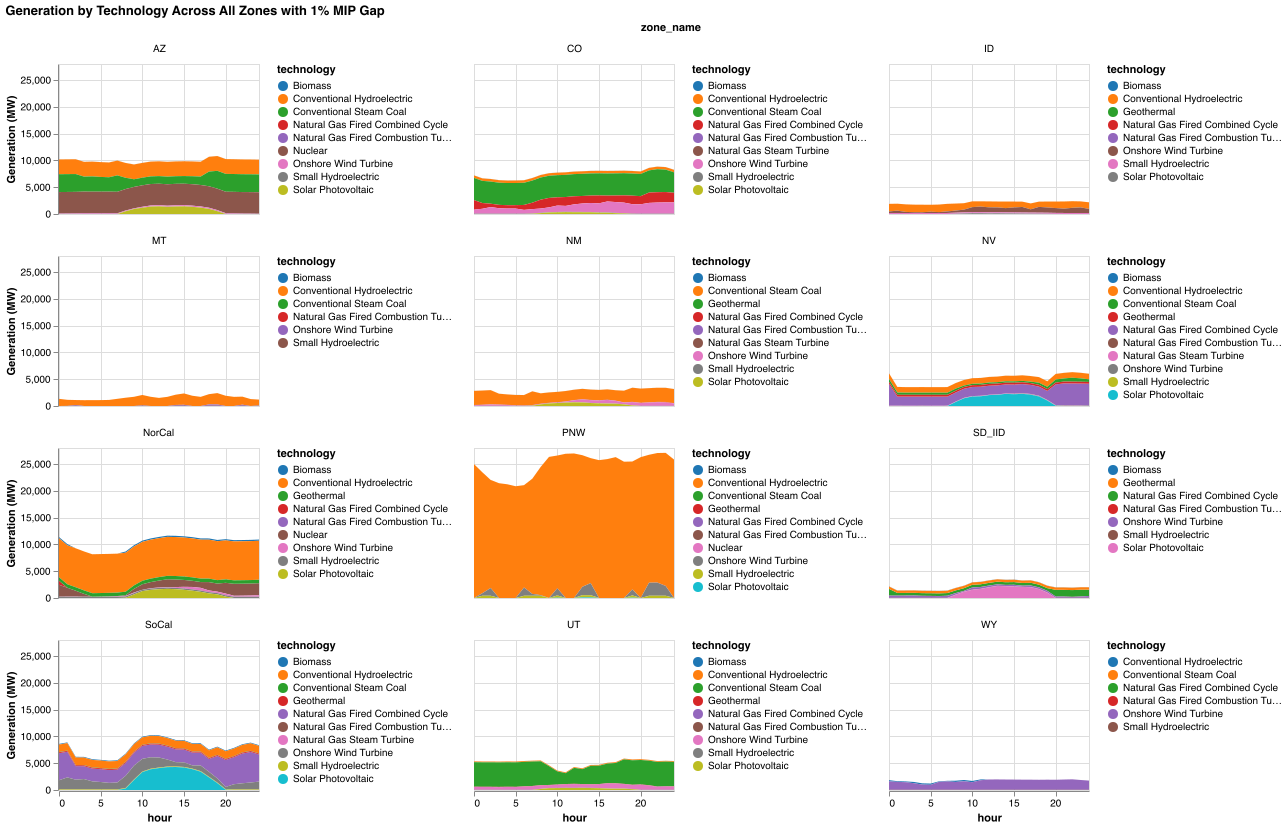

In [4]:
include("../src/plots.jl")
sol_gen_zone = plot_generation_by_zone(
    solution, T_period, gen_df, zone_dict,
    "Generation by Technology Across All Zones with 1% MIP Gap"
    );

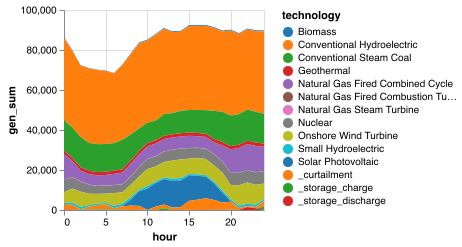

In [5]:
total_gen = plot_total_generation(
    solution, T_period, gen_df, zone_dict,
    "Total Generation by Technology with 1% MIP Gap"
    );